In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
ht = pd.read_csv("dataset23.csv")

In [3]:
ht.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
ht.shape

(43400, 12)

# Missing Value

In [5]:
ht.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [6]:
(ht["bmi"].isnull().sum() / ht.shape[0]) * 100

3.3686635944700463

In [7]:
(ht["smoking_status"].isnull().sum() / ht.shape[0]) * 100

30.62672811059908

In [8]:
ht.dropna(axis=0,inplace=True)
ht.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [9]:
ht.shape

(29072, 12)

In [10]:
def col_names(df):
    #Categorical Variables
    cat_cols = [col for col in ht.columns if ht[col].dtypes not in ["int64", "float64"]]
    #Numerical Variables
    num_cols = [col for col in ht.columns if ht[col].dtypes in ["int64", "float64"]]
    #Numerical but Categorical Variables
    num_but_cat = [col for col in num_cols if ht[col].nunique() < 12]
    #Adding num_but_cat to cat_cols
    cat_cols = num_but_cat + cat_cols
    #num_but_cat removing from num_cols
    num_cols = [col for col in num_cols if col not in num_but_cat]
    #Categorical but Cardinal Variables
    cat_but_car = [col for col in cat_cols if ht[col].nunique() > 12]
    print(f"Numerical Cols: {num_cols} \nCategorical Cols: {cat_cols} \nNumerical but Categorical: {num_but_cat} \nCategorical but Cardinal: {cat_but_car}") 
    return num_cols, cat_cols

In [11]:
num_cols, cat_cols = col_names(ht)

Numerical Cols: ['id', 'age', 'avg_glucose_level', 'bmi'] 
Categorical Cols: ['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] 
Numerical but Categorical: ['hypertension', 'heart_disease', 'stroke'] 
Categorical but Cardinal: []


# Analyzing Numerical Variables

In [12]:
ht[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,29072.0,37079.469455,20965.429393,1.00,19046.7500,37444.00,55220.25,72943.00
age,29072.0,47.671746,18.734490,10.00,32.0000,48.00,62.00,82.00
avg_glucose_level,29072.0,106.403225,45.268512,55.01,77.6275,92.13,113.91,291.05
bmi,29072.0,30.054166,7.193908,10.10,25.0000,28.90,33.90,92.00


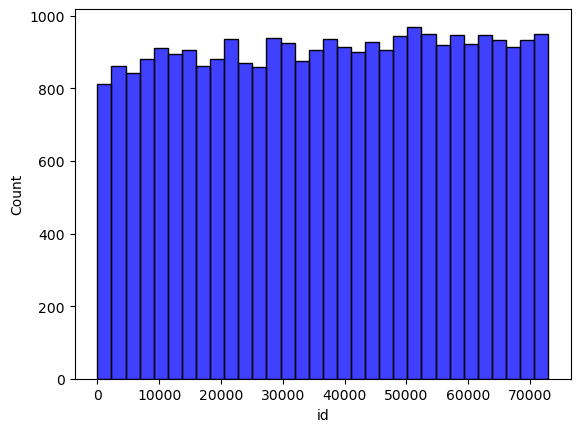

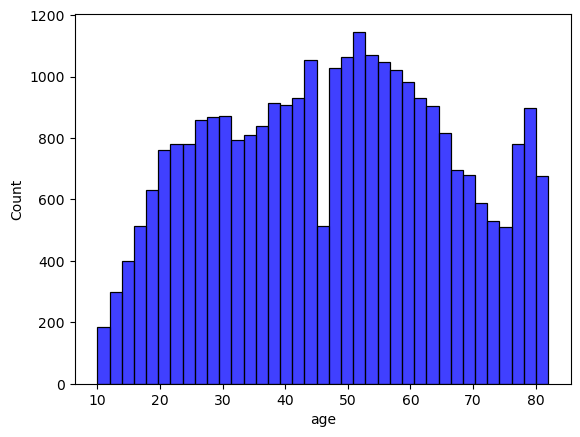

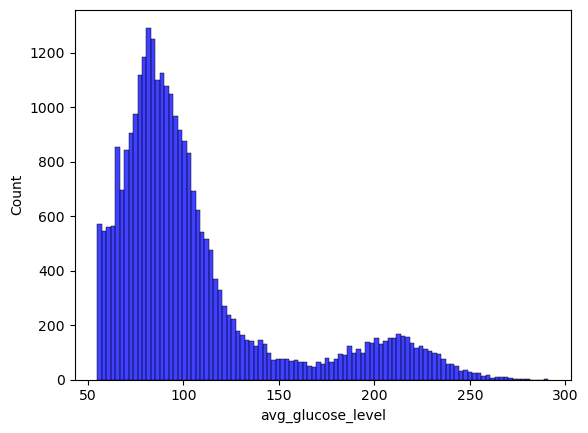

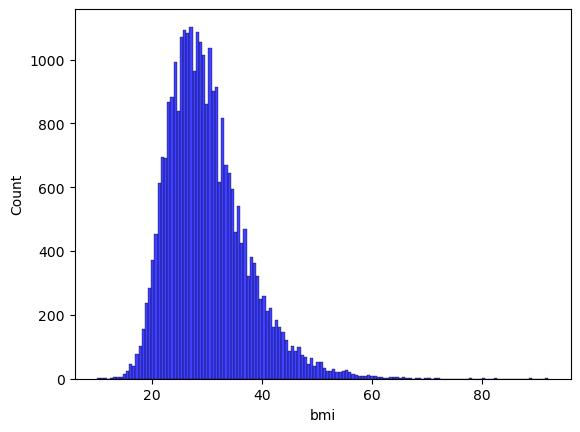

In [13]:
for col in num_cols:
    sns.histplot(x=ht[col], data=ht, color="blue")
    plt.show(block=True)

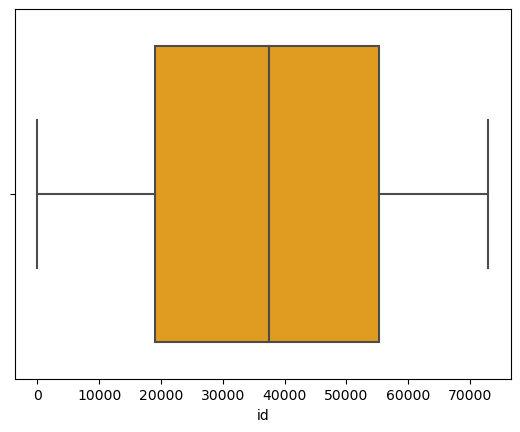

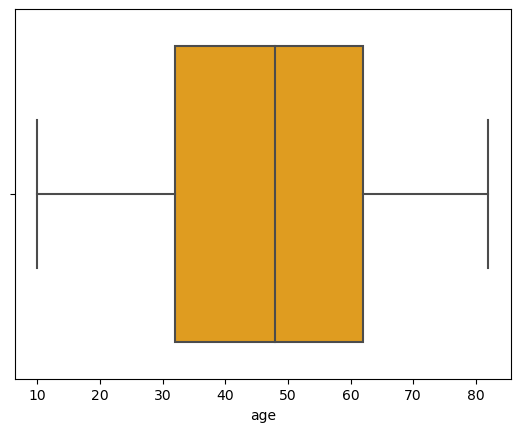

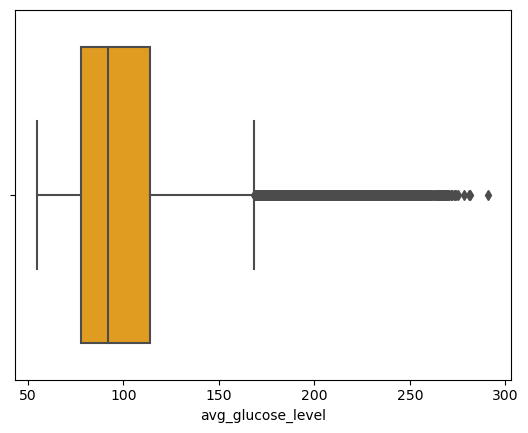

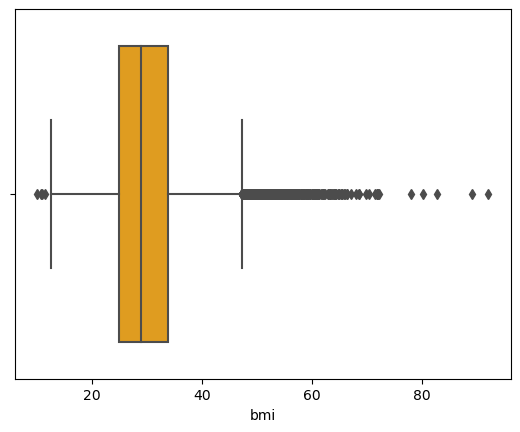

In [14]:
for col in num_cols:
    sns.boxplot(x=ht[col], data=ht, color="orange")
    plt.show(block=True)

# Analyzing Categorical Variables

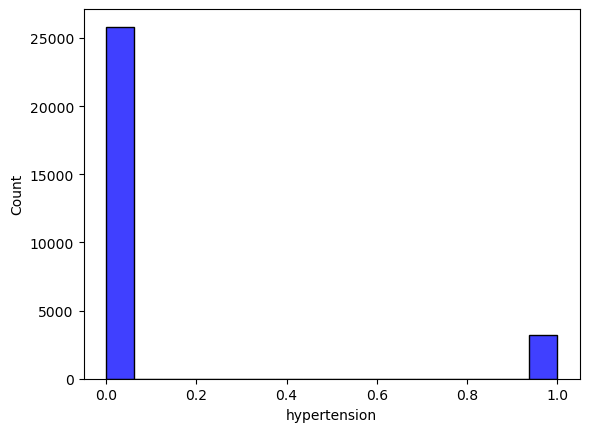

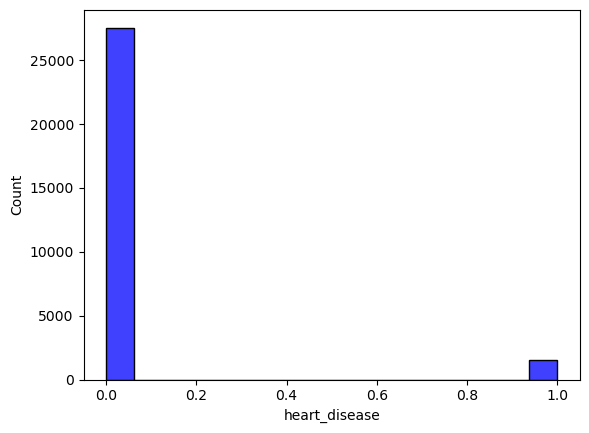

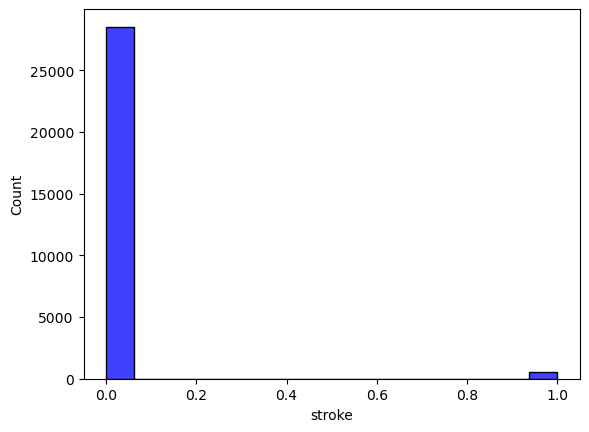

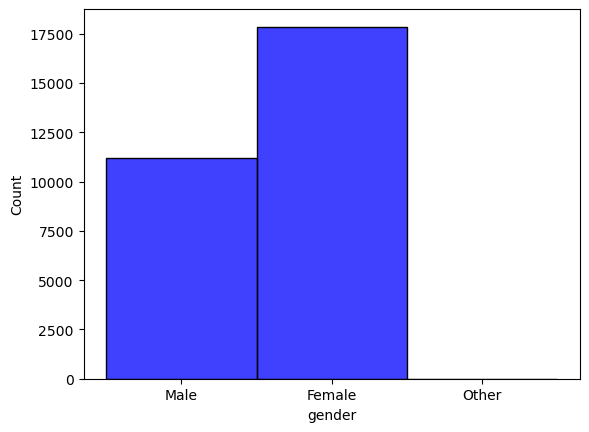

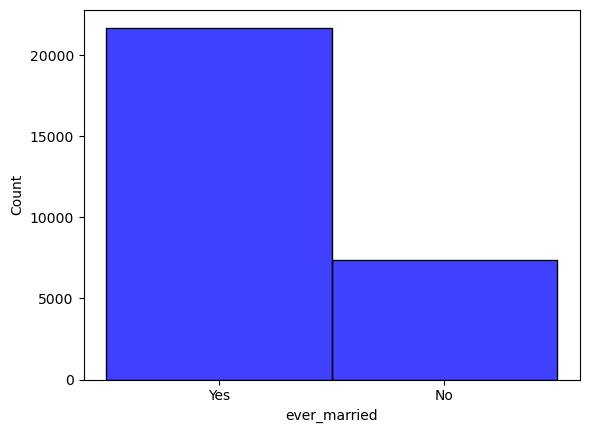

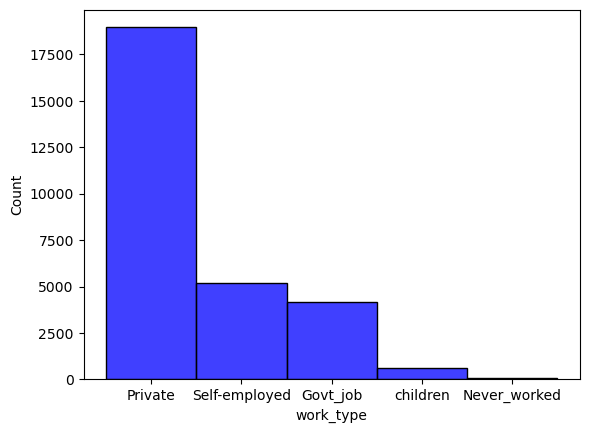

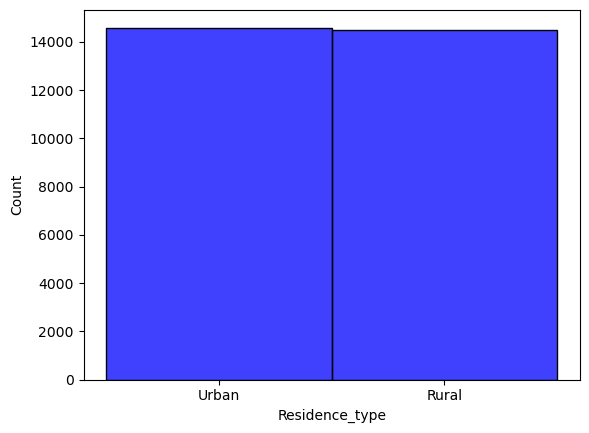

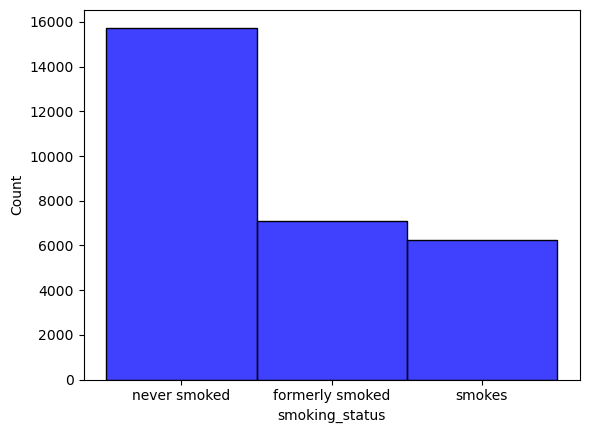

In [15]:
for col in cat_cols:
    sns.histplot(x=ht[col], data=ht, color="blue")
    plt.show(block=True)

# Analyzing Target Variable

In [16]:
ht["stroke"].value_counts()

0    28524
1      548
Name: stroke, dtype: int64

([<matplotlib.patches.Wedge at 0x1c431e96e50>,
 [Text(-1.0980718278468278, 0.06510192692330162, '0'),
  Text(1.2977212564943388, -0.07693854978328195, '1')],
 [Text(-0.5989482697346332, 0.035510141958164515, '98.1%'),
  Text(0.7985976963042085, -0.047346799866635036, '1.9%')])

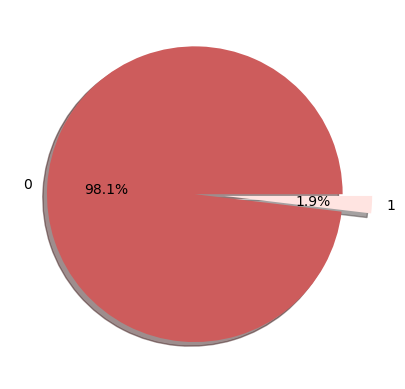

In [17]:
plt.pie(ht["stroke"].value_counts(), labels=[0,1], shadow=True, colors=["indianred", "mistyrose"], explode=(0,0.2), autopct="%1.1f%%")



Ratio of 1s is %4.9

# Checking for Outliers in Numerical Variables

In [18]:
def check_outliers(ht, numerical_cols, low_threshold=0.1, up_threshold=0.9):
    outlier_cols = []
    for col in numerical_cols:
        q1 = ht[col].quantile(low_threshold)
        q3 = ht[col].quantile(up_threshold)
        interquantile = q3 - q1
        up_limit = q3 + 1.5 * interquantile
        low_limit = q1 - 1.5 * interquantile
        if ht[(ht[col] > up_limit) | (ht[col] < low_limit)].any(axis=None):
            outlier_cols.append(col)
    if not outlier_cols:
        print("There is no outliers")
    return outlier_cols

In [19]:
outlier_cols = check_outliers(ht, num_cols)

In [20]:
print(outlier_cols)

['bmi']


There are outliers in "bmi"

# Correlation

<Axes: >

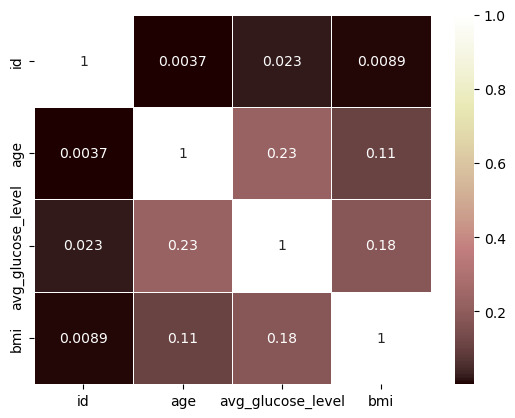

In [21]:
sns.heatmap(ht[num_cols].corr(), annot=True, linewidths=0.5, cmap="pink")

No highly corelated columns

# Target Variable vs Numerical Columns

In [22]:
for col in num_cols:
    print(ht.groupby("stroke").agg({col:"mean"}), end="\n\n")

                  id
stroke              
0       37080.877331
1       37006.187956

              age
stroke           
0       47.271701
1       68.494526

        avg_glucose_level
stroke                   
0              105.929806
1              131.045182

              bmi
stroke           
0       30.058183
1       29.845073



According to the results, the probability of having a stroke increases with age, glucose level and bmi

# Target Variable vs Categorical Columns

In [23]:
for col in cat_cols:
    print(pd.DataFrame({"target_mean": ht.groupby(col)["stroke"].mean()}), end="\n\n")

              target_mean
hypertension             
0                0.015059
1                0.049059

               target_mean
heart_disease             
0                 0.015496
1                 0.079815

        target_mean
stroke             
0               0.0
1               1.0

        target_mean
gender             
Female     0.017533
Male       0.020958
Other      0.000000

              target_mean
ever_married             
No               0.007721
Yes              0.022637

               target_mean
work_type                 
Govt_job          0.015729
Never_worked      0.000000
Private           0.016408
Self-employed     0.032859
children          0.000000

                target_mean
Residence_type             
Rural              0.018581
Urban              0.019116

                 target_mean
smoking_status              
formerly smoked     0.025356
never smoked        0.016257
smokes              0.017989



According to the results,

People with hypertension are more likely to have a stroke

People with heart disease are more likely to have a stroke

The probability of having a stroke is higher in men

People who have been married are more likely to have a stroke

People who are self-employed are more likely to have a stroke

The probability of having a stroke is higher in urban life

The probability of having a stroke is higher in formerly smoked people

# Feature Engineering

Label Encoder

In [24]:
binary_cols = [col for col in ht.columns if ht[col].dtype not in ["int64", "float64"] and ht[col].nunique() == 2]

In [25]:
binary_cols

['ever_married', 'Residence_type']

In [26]:
le = LabelEncoder()

In [27]:
for col in binary_cols:
    ht[col] = le.fit_transform(ht[col])

In [28]:
ht.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,Male,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0
3,56543,Female,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0
6,52800,Female,52.0,0,0,1,Private,1,77.59,17.7,formerly smoked,0
7,41413,Female,75.0,0,1,1,Self-employed,0,243.53,27.0,never smoked,0
8,15266,Female,32.0,0,0,1,Private,0,77.67,32.3,smokes,0


# One Hot Encoder

In [29]:
ohe_cols = [col for col in ht.columns if 2 < ht[col].nunique() < 10]

In [30]:
ohe_cols

['gender', 'work_type', 'smoking_status']

In [31]:
ht = pd.get_dummies(ht, columns=ohe_cols, drop_first=True)

In [32]:
ht.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_never smoked,smoking_status_smokes
1,30468,58.0,1,0,1,1,87.96,39.2,0,1,0,0,1,0,0,1,0
3,56543,70.0,0,0,1,0,69.04,35.9,0,0,0,0,1,0,0,0,0
6,52800,52.0,0,0,1,1,77.59,17.7,0,0,0,0,1,0,0,0,0
7,41413,75.0,0,1,1,0,243.53,27.0,0,0,0,0,0,1,0,1,0
8,15266,32.0,0,0,1,0,77.67,32.3,0,0,0,0,1,0,0,0,1


# Checking & Eliminate Outliers

In [33]:
def replace_with_thresholds(ht, col, low_threshold=0.1, up_threshold=0.9):
    q1 = ht[col].quantile(low_threshold)
    q3 = ht[col].quantile(up_threshold)
    interquantile = q3 - q1
    up_limit = q3 + 1.5 * interquantile
    low_limit = q1 - 1.5 * interquantile
    ht.loc[(ht[col] < low_limit), col] = low_limit
    ht.loc[(ht[col] > up_limit), col] = up_limit

In [34]:
for col in outlier_cols:
    replace_with_thresholds(ht, col)

In [35]:
check_outliers(ht, num_cols)

There is no outliers


[]

# Feature Scaling

In [36]:

sc = MinMaxScaler()

In [37]:
ht["age"] = sc.fit_transform(ht[["age"]])
ht["bmi"] = sc.fit_transform(ht[["bmi"]])
ht["avg_glucose_level"] = sc.fit_transform(ht[["avg_glucose_level"]])

In [38]:
ht.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_never smoked,smoking_status_smokes
1,30468,0.666667,1,0,1,1,0.139595,0.526697,0,1,0,0,1,0,0,1,0
3,56543,0.833333,0,0,1,0,0.059439,0.466968,0,0,0,0,1,0,0,0,0
6,52800,0.583333,0,0,1,1,0.095662,0.137557,0,0,0,0,1,0,0,0,0
7,41413,0.902778,0,1,1,0,0.798678,0.305882,0,0,0,0,0,1,0,1,0
8,15266,0.305556,0,0,1,0,0.096001,0.401810,0,0,0,0,1,0,0,0,1


# Model Building

In [39]:
y = ht["stroke"]
X = ht.drop(["stroke", "id"], axis=1)

In [40]:
models = [("LR", LogisticRegression()),
          ("KNN", KNeighborsClassifier()),
          ("DecisionTree", DecisionTreeClassifier()),
          ("RF", RandomForestClassifier()),
          ("SVC", SVC()),
          ("GBM", GradientBoostingClassifier()),
          ("XGBoost", XGBClassifier())]

In [41]:
for name, regressor in models:
    cv = cross_validate(regressor, X, y, cv=5, scoring=["accuracy", "f1", "recall", "precision"])
    print(f'{name} \n {"Accuracy"}:{cv["test_accuracy"].mean()} \n {"Recall"}:{cv["test_recall"].mean()} \n {"Precision"}:{cv["test_precision"].mean()} \n {"F-Score"}:{cv["test_f1"].mean()}')

LR 
 Accuracy:0.9811502522597187 
 Recall:0.0 
 Precision:0.0 
 F-Score:0.0
KNN 
 Accuracy:0.9807374969719073 
 Recall:0.0 
 Precision:0.0 
 F-Score:0.0
DecisionTree 
 Accuracy:0.9609934865319014 
 Recall:0.08398665554628858 
 Precision:0.0683935698016262 
 F-Score:0.07529103729604049
RF 
 Accuracy:0.9809094778488548 
 Recall:0.001834862385321101 
 Precision:0.06666666666666667 
 F-Score:0.0035714285714285718
SVC 
 Accuracy:0.9811502522597187 
 Recall:0.0 
 Precision:0.0 
 F-Score:0.0
GBM 
 Accuracy:0.9801183078411555 
 Recall:0.0 
 Precision:0.0 
 F-Score:0.0
XGBoost 
 Accuracy:0.980806284590136 
 Recall:0.005471226021684737 
 Precision:0.25 
 F-Score:0.010682680151706703


# SMOTE

In [42]:
from imblearn.over_sampling import SMOTE

In [43]:
sm = SMOTE()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
sum(y_train == 1) 

440

There are 440 data equal to 1

In [46]:
sum(y_train == 0)

22817

There are 22817 data equal to 0

In [47]:
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [48]:
sum(y_train_smote == 1)

22817

There are 22817 data equal to 1

In [49]:
sum(y_train_smote == 0)

22817

There are 22817 data equal to 0

In [50]:
for name, regressor in models:
    regressor.fit(X_train_smote, y_train_smote)
    pre = regressor.predict(X_test)
    print(f'{name}\nConfusion Matrix: \n{confusion_matrix(y_test, pre)}\n{classification_report(y_test, pre)}\n')

LR
Confusion Matrix: 
[[4139 1568]
 [  24   84]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      5707
           1       0.05      0.78      0.10       108

    accuracy                           0.73      5815
   macro avg       0.52      0.75      0.47      5815
weighted avg       0.98      0.73      0.82      5815


KNN
Confusion Matrix: 
[[4836  871]
 [  75   33]]
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5707
           1       0.04      0.31      0.07       108

    accuracy                           0.84      5815
   macro avg       0.51      0.58      0.49      5815
weighted avg       0.97      0.84      0.90      5815


DecisionTree
Confusion Matrix: 
[[5382  325]
 [  94   14]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5707
           1       0.04      0.13      0.06       108

    accuracy          

Logistic Regression can be use with recall score of 78%

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
logModel=LogisticRegression()

In [53]:
param_grid = [{'penalty' :['l1','l2','elasticnet','none'],
               'C':np.logspace(-4,4,20),
               'solver':['lbfgs','newton-cg','liblinear','sag','saga'],
              'max_iter':[100,1000,2500,5000]
              }
]

In [54]:
clf = GridSearchCV(logModel,param_grid,cv=3,verbose=True,n_jobs=-1)

In [55]:
best_clf =clf.fit(X,y)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


In [56]:
best_clf.best_estimator_

LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')

In [57]:
print(f'Accuracy - : {best_clf.score(X,y):.3f}')

Accuracy - : 0.981
